In [2]:
# External Dependencies
import os                          # Access system file-tree
import sys                         # Modify system parameters
from math import isclose           # isclose()
import numpy as np                 # Data structures
from optparse import OptionParser  # Get user input
import matplotlib.ticker as mticker  # Scientific notation in labels
from matplotlib.ticker import FuncFormatter

np.set_printoptions(threshold=sys.maxsize, precision=16)

In [3]:
# Internal Dependencies
internalPath = os.getcwd() + "/../python"
print(internalPath)
sys.path.insert(0, internalPath)
from plotStyling import PlotStyling  # noqa: E402
from GSDUtil import GSDUtil  # noqa: E402

/Users/alecglisman/Dropbox/3_Brady_Lab/Code/potential-flow/bodies-in-potential-flow/jupyter_notebooks/../python


In [4]:
# Parameters
relative_path = os.getcwd() + "/../data/2021-08-26.01-15-39_collinear-swimmer-wall_varyZHeight"
output_dir = "figures"
output_dir = relative_path + "/" + output_dir + "/"
gsd_files = []
epsOutput = True

# Correctly get scientific notation in text elements
def scientific(x, pos):
    return '%0.2e' % x

scientific_formatter = FuncFormatter(scientific)
fmt = mticker.FuncFormatter(scientific_formatter)

In [5]:
# Load data from GSD

try:
    # Loop through all subdirectories in the 'data' directory
    for root, dirs, files in os.walk(relative_path, topdown=True):
        dirs.sort()
        files.sort()

        for file in files:  # Loop through all files in given directory
            if (".gsd" in file):
                with open(root + "/" + file) as g:
                    cur_gsd = GSDUtil(g.name, create_gsd=False)
                    gsd_files.append(cur_gsd)

    assert(len(gsd_files) > 0)

except:  # No files found
    raise IOError(
        f"Failure to load data. No files found in relPath {relative_path}")

In [6]:
# Load data into np structures

CoM_disp = np.zeros(len(gsd_files), dtype=np.double)
R_avg = np.zeros_like(CoM_disp, dtype=np.double)
Z_height = np.zeros_like(CoM_disp, dtype=np.double)
phaseShift = np.zeros_like(CoM_disp, dtype=np.double)
U0 = np.zeros_like(CoM_disp, dtype=np.double)
omega = np.zeros_like(CoM_disp, dtype=np.double)
epsilon = np.zeros_like(CoM_disp, dtype=np.double)
final_t = np.zeros_like(CoM_disp, dtype=np.double)

for i in range(len(gsd_files)):

    # Data from final frame
    gsd_files[i].snapshot = gsd_files[i].trajectory.read_frame(
        gsd_files[i].trajectory.file.nframes - 1)
    final_t[i] = gsd_files[i].snapshot.log['integrator/t']
    CoM_disp_comp = gsd_files[i].snapshot.log['particles/double_position'][1]

    # Data from initial frame (not 0)
    gsd_files[i].snapshot = gsd_files[i].trajectory.read_frame(1)
    R_avg[i] = gsd_files[i].snapshot.log['swimmer/R_avg']
    Z_height[i] = gsd_files[i].snapshot.log['swimmer/Z_height']
    phaseShift[i] = gsd_files[i].snapshot.log['swimmer/phase_shift']
    U0[i] = gsd_files[i].snapshot.log['swimmer/U0']
    omega[i] = gsd_files[i].snapshot.log['swimmer/omega']
    epsilon[i] = U0[i] / R_avg[i] / omega[i]
    CoM_disp_comp -= gsd_files[i].snapshot.log['particles/double_position'][1]

    CoM_disp[i] = np.linalg.norm(CoM_disp_comp)

In [7]:
# NOTE: Assuming each GSD has same number of frames
nframes = gsd_files[0].trajectory.file.nframes

# ANCHOR: Orientation vector (not unit norm)
q = np.zeros((len(gsd_files), 3, nframes - 2), dtype=np.double)
q0 = np.zeros((len(gsd_files), 3), dtype=np.double)

# ANCHOR: temporal data
time = np.zeros((len(gsd_files), nframes - 2), dtype=np.double)

# ANCHOR: kinematic data (simulation_number, particle_number, dimension_number, frame_number)
positions = np.zeros((len(gsd_files), 6, 3, nframes - 2), dtype=np.double)
velocities = np.zeros_like(positions, dtype=np.double)
accelerations = np.zeros_like(positions, dtype=np.double)

In [8]:
for i in range(len(gsd_files)):  # loop over all GSD files

    gsd_current = gsd_files[i]
    q_current = np.zeros((3, nframes - 2), dtype=np.double)
    q_current_norm = np.zeros((nframes - 2), dtype=np.double)


    for j in range(1, nframes - 1):  # loop over all frames in GSD file

        snapshot_current = gsd_current.trajectory.read_frame(j)

        q_current[:, j - 1] = snapshot_current.log['particles/double_position'][0]
        q_current[:, j - 1] -= snapshot_current.log['particles/double_position'][2]

        time[i, j - 1] = snapshot_current.log['integrator/t']
        
        positions[i, :, :, j - 1] = snapshot_current.log['particles/double_position']
        velocities[i, :, :, j -
                   1] = snapshot_current.log['particles/double_velocity']
        accelerations[i, :, :,  -
                      1] = snapshot_current.log['particles/double_moment_inertia']

    q[i, :, :] = q_current

q0 = q[:, :, 0]

In [9]:
q0 = q[:, :, 0]
q0_norm = np.linalg.norm(q0, axis=1)
q0 = np.divide(q0, q0_norm[:, np.newaxis])

print(q0)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [10]:
# ANCHOR: Angular orientational displacement
theta = np.zeros((len(gsd_files), nframes - 2), dtype=np.double)
theta_norm = np.zeros((nframes - 2), dtype=np.double)

for i in range(len(gsd_files)):

    theta[i, :] = np.dot(q0[i, :].reshape(1, 3), q[i, :, :]) 
    
    print(np.array(theta[i,0] - theta[i,960], dtype=np.double))
    
    theta_norm = np.linalg.norm(q0[i, :]) * np.linalg.norm(q[i, :, :], axis=0)
    theta[i, :] = theta[i, :] / theta_norm

print(np.array(theta[:, 0] - theta[:, 960], dtype=np.double))

-2.9363018683170594e-08
-2.93636546189191e-08
-2.9371248544407536e-08
-2.9386004740672433e-08
-2.9354122688118878e-08
-2.93776896143072e-08
-2.9344791485641508e-08
-2.9339965124108858e-08
-2.9380849753124494e-08
-2.9358371733678723e-08
-2.9377202892533205e-08
-2.9332959172734263e-08
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# relative separation between particle pairs
R_loc = positions[:, 1, :, :]
R_loc_init = positions[:, 1, :, 0]
DR_loc = R_loc - R_loc_init[:, :, np.newaxis]
R_12 = positions[:, 0, :, :] - R_loc
R_32 = positions[:, 2, :, :] - R_loc
# distance between particle pairs
Dr_Loc = np.linalg.norm(DR_loc, axis=1)
r_12 = np.linalg.norm(R_12, axis=1)
r_32 = np.linalg.norm(R_32, axis=1)

print(r_12[0,0]-r_12[0,960])
print(time[0,960]-24.0)

-2.541761023877598e-08
3.000764081662055e-09


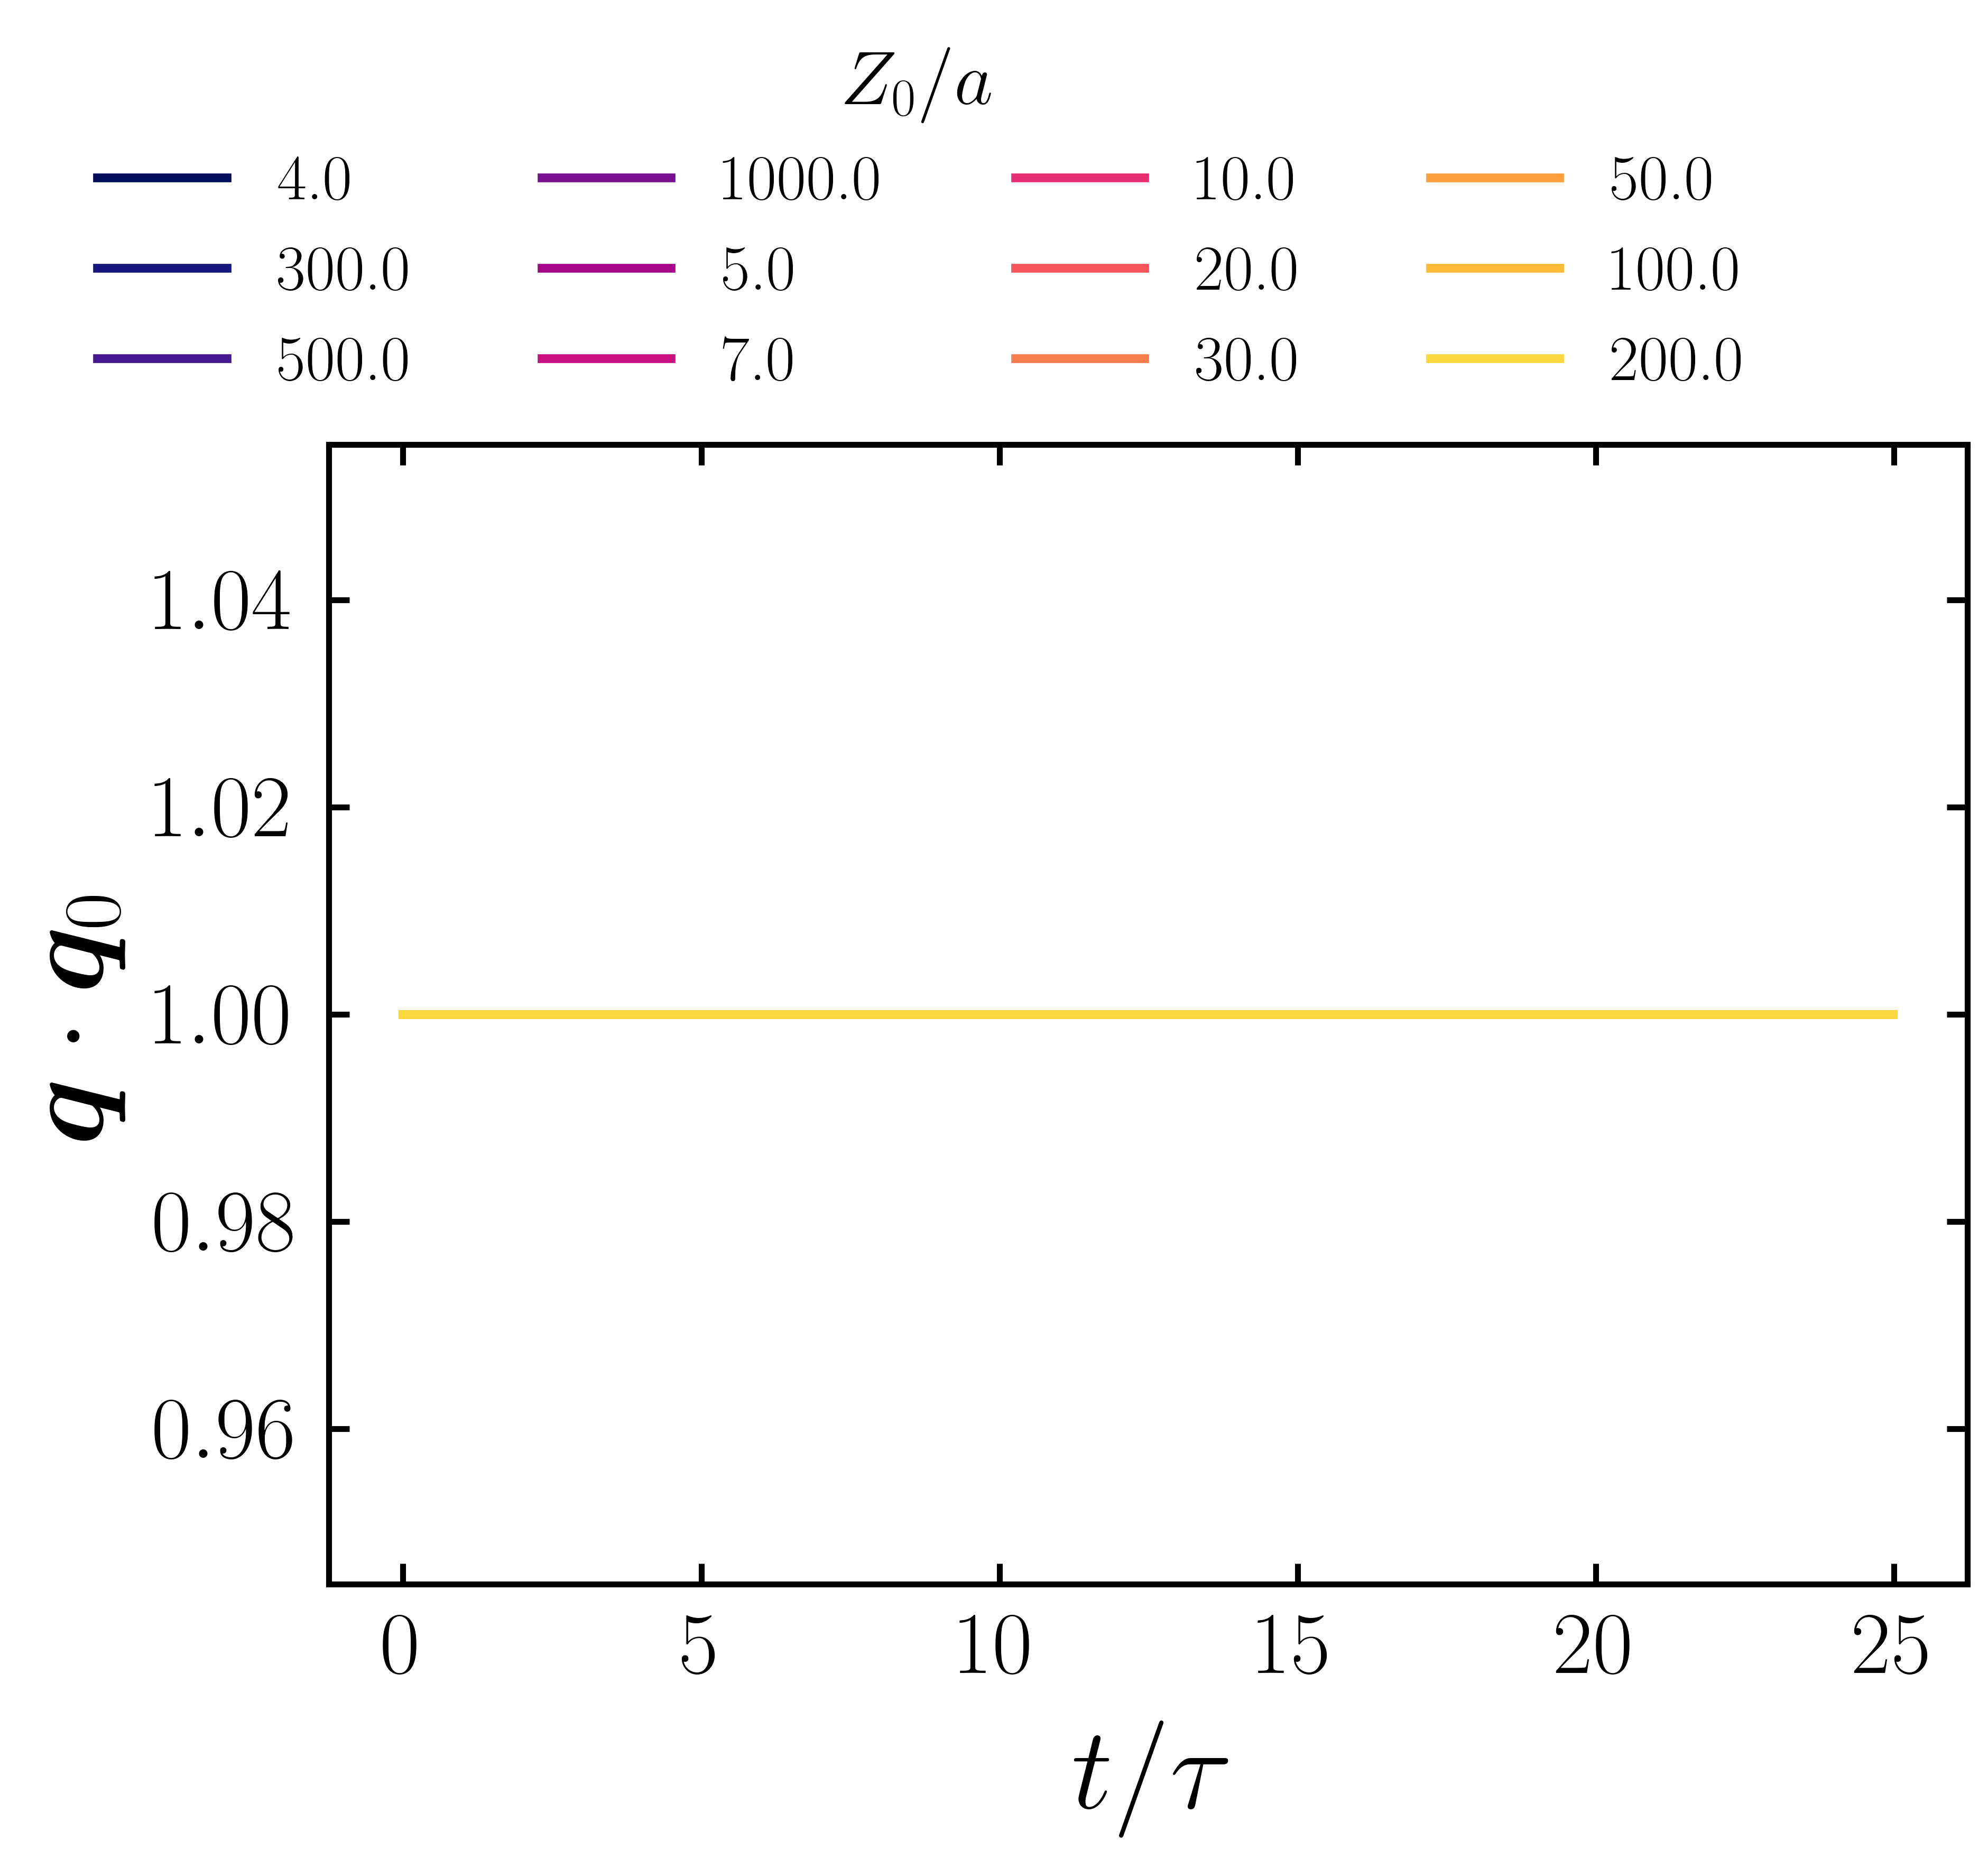

In [23]:
# PLOT: Angular orientaional dynamics

# PLOT: Locater point position (x-axis)
numLines = len(gsd_files)
orientDyn_Plot = PlotStyling(numLines,
                          r"$t/\tau$", r"$ \bm{q} \cdot \bm{q}_{0}$",
                          title=None, loglog=False,
                          outputDir=output_dir, figName="orientation", eps=epsOutput,
                          continuousColors=True)
# Show numerical data points
orientDyn_Plot.make_plot(showPlot=True)

for i in range(len(gsd_files)):
    orientDyn_Plot.curve(time[i, :], theta[i, :], zorder=i, label=f"{Z_height[i]}")

orientDyn_Plot.legend(title=r"$Z_0/a$",
    loc='best', ncol=4, bbox_to_anchor=(-0.1, 1.0, 1.0, 0.4))
orientDyn_Plot.fig

dR_x = 0.2999827017605349
dR_y = 5.788253666103561e-15
dR_z = -0.775487976518793


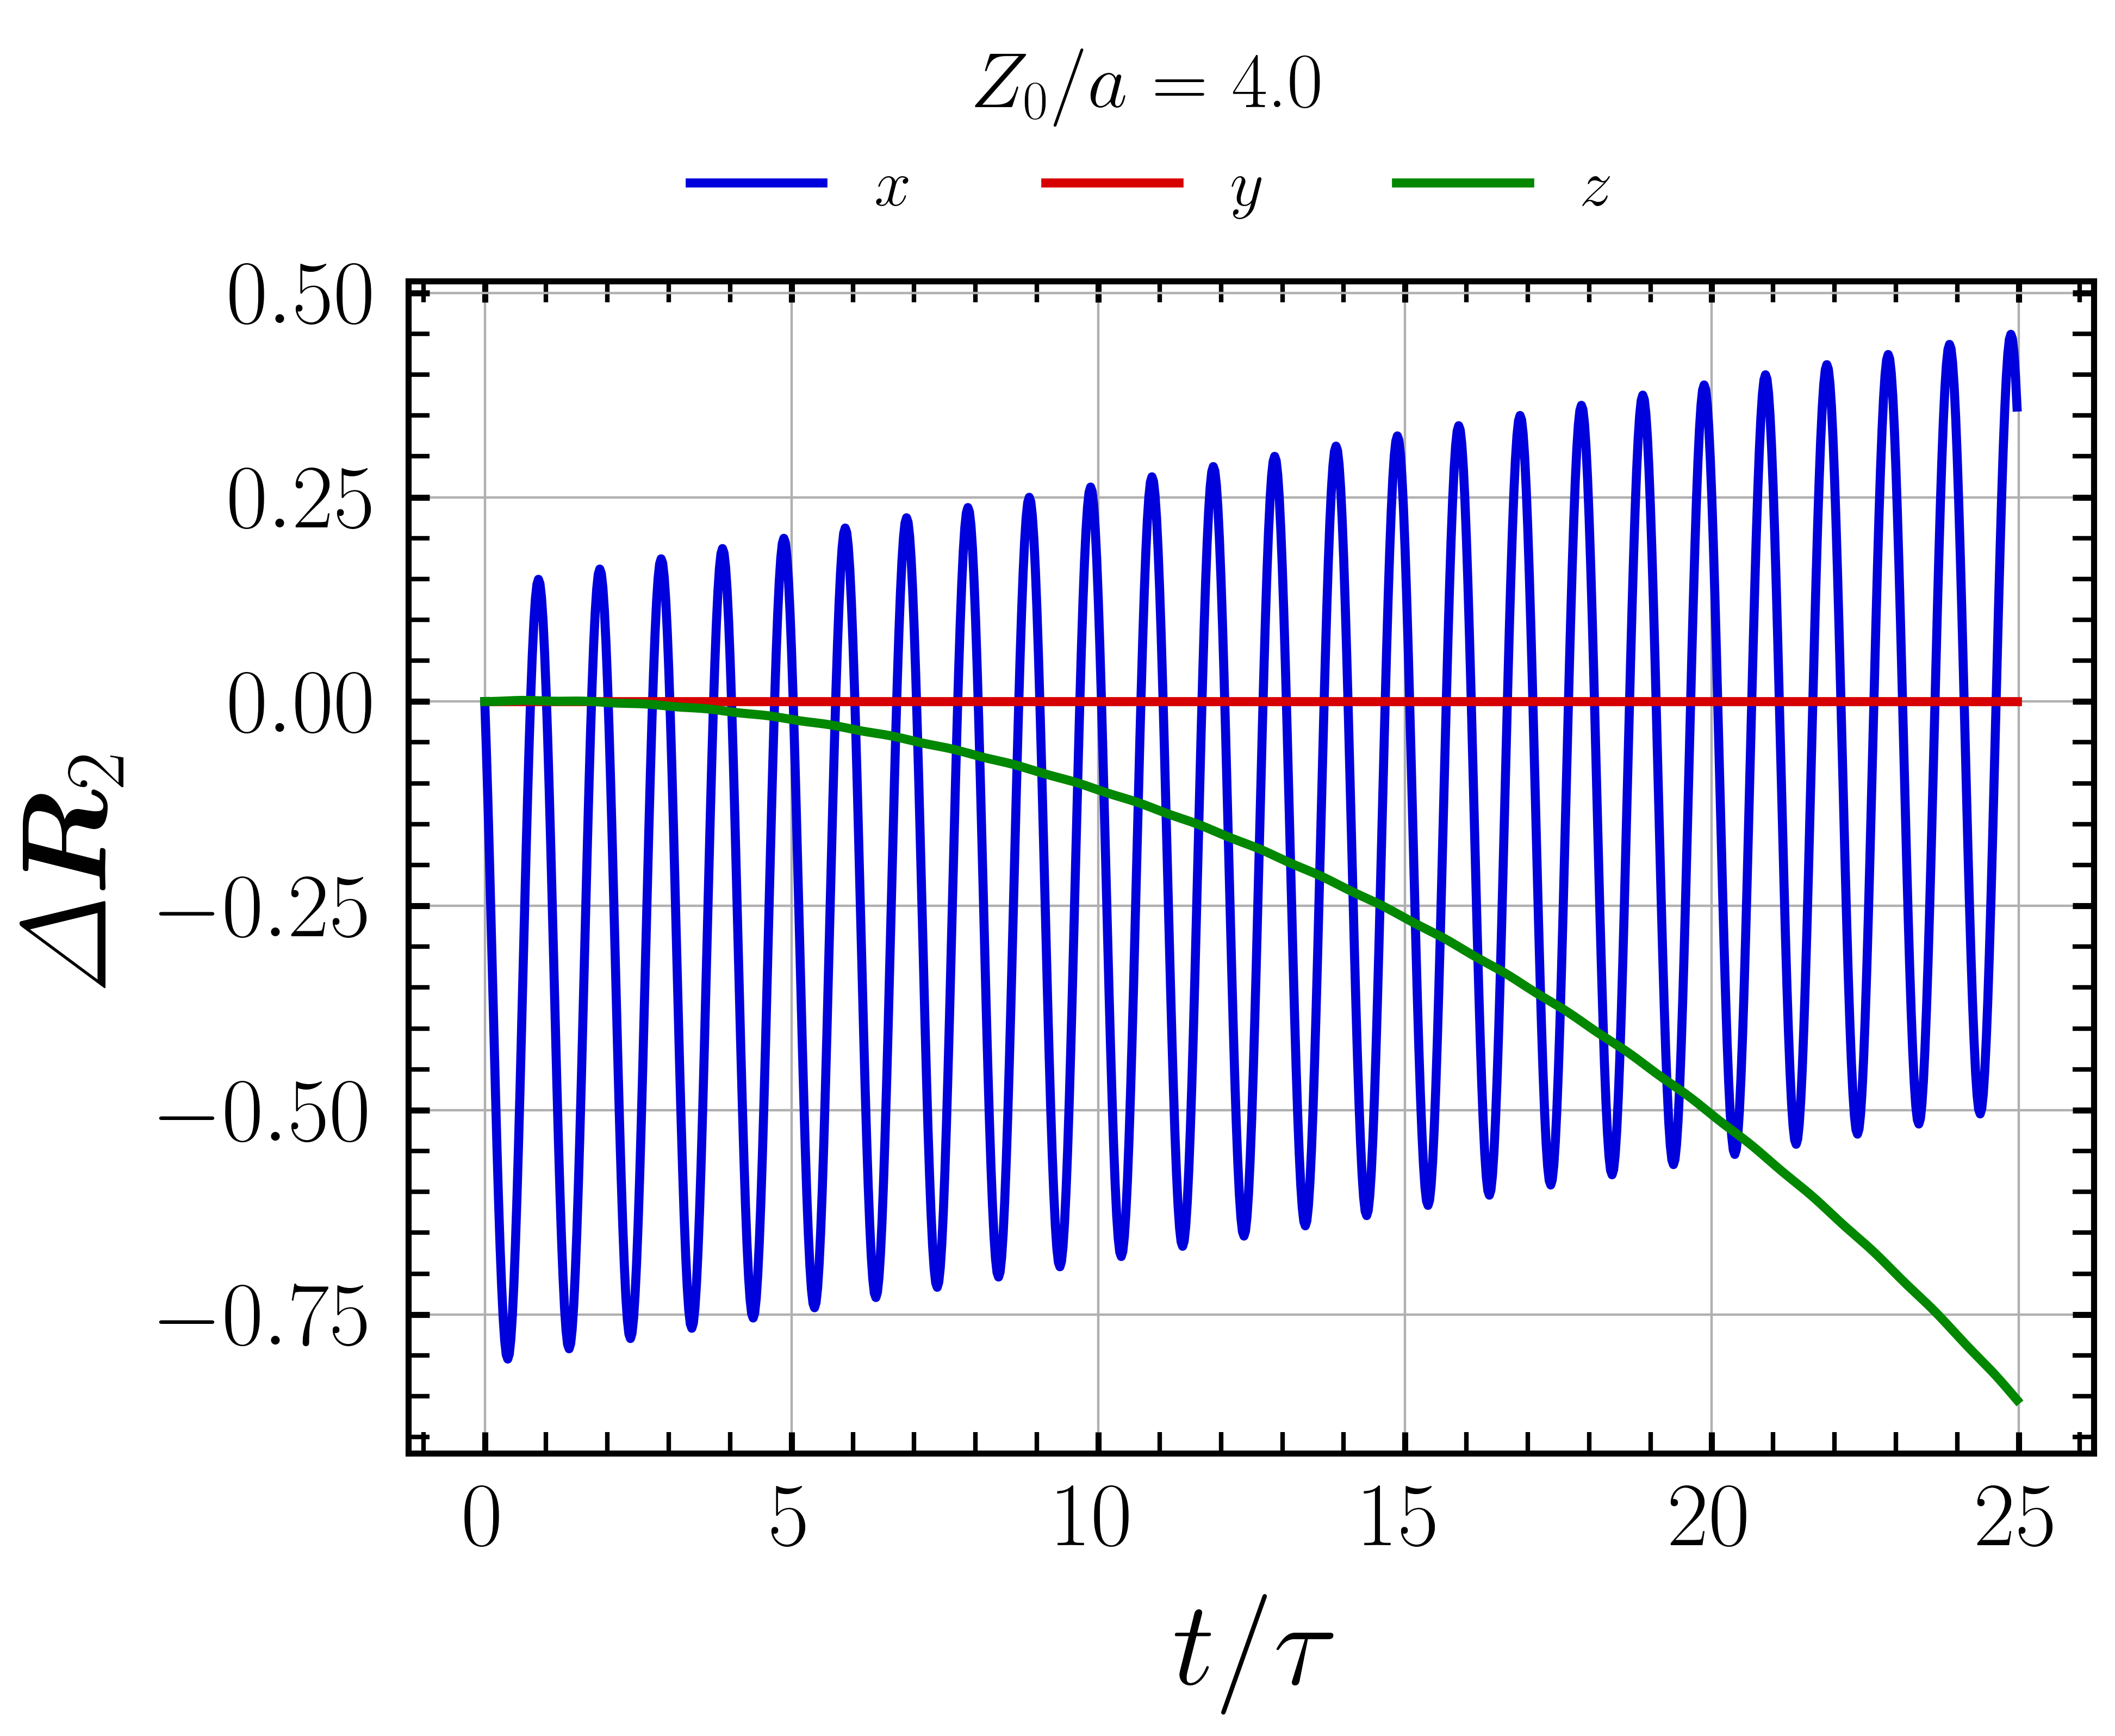

In [56]:
# PLOT: Position of particle 2
simNumber = 0

numLines = 3
p2Pos_Plot = PlotStyling(numLines,
                         r"$t/\tau$", r"$ \Delta \bm{R}_{2}$",
                         title=None, loglog=False,
                         outputDir=output_dir, figName="particle-2-pos", eps=epsOutput,
                         continuousColors=False)
# Show numerical data points
p2Pos_Plot.make_plot(showPlot=True)
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 0, :], zorder=i, label=r"$x$")
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 1, :], zorder=i, label=r"$y$")
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 2, :], zorder=i, label=r"$z$")
# plot elements
p2Pos_Plot.set_major_minor_ticks(
    xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.25, yMinorLoc=0.05)
p2Pos_Plot.ax.grid('True')
# text elements
p2Pos_Plot.legend(title=r"$Z_0/a$ = " + f"{Z_height[simNumber]}",
                  loc='best', ncol=3, bbox_to_anchor=(0.05, 0.05, 0.7, 1.2))


# other outputs
dR_x_close = DR_loc[simNumber, 0, 960] - DR_loc[simNumber, 0, 0]
print(f"dR_x = {DR_loc[simNumber, 0, 960] - DR_loc[simNumber, 0, 0]}")
print(f"dR_y = {DR_loc[simNumber, 1, 960] - DR_loc[simNumber, 1, 0]}")
print(f"dR_z = {DR_loc[simNumber, 2, 960] - DR_loc[simNumber, 2, 0]}")

# show plot
p2Pos_Plot.fig


dR_x = 0.3058214400825831
dR_y = -3.87787704180518e-14
dR_z = 0.0


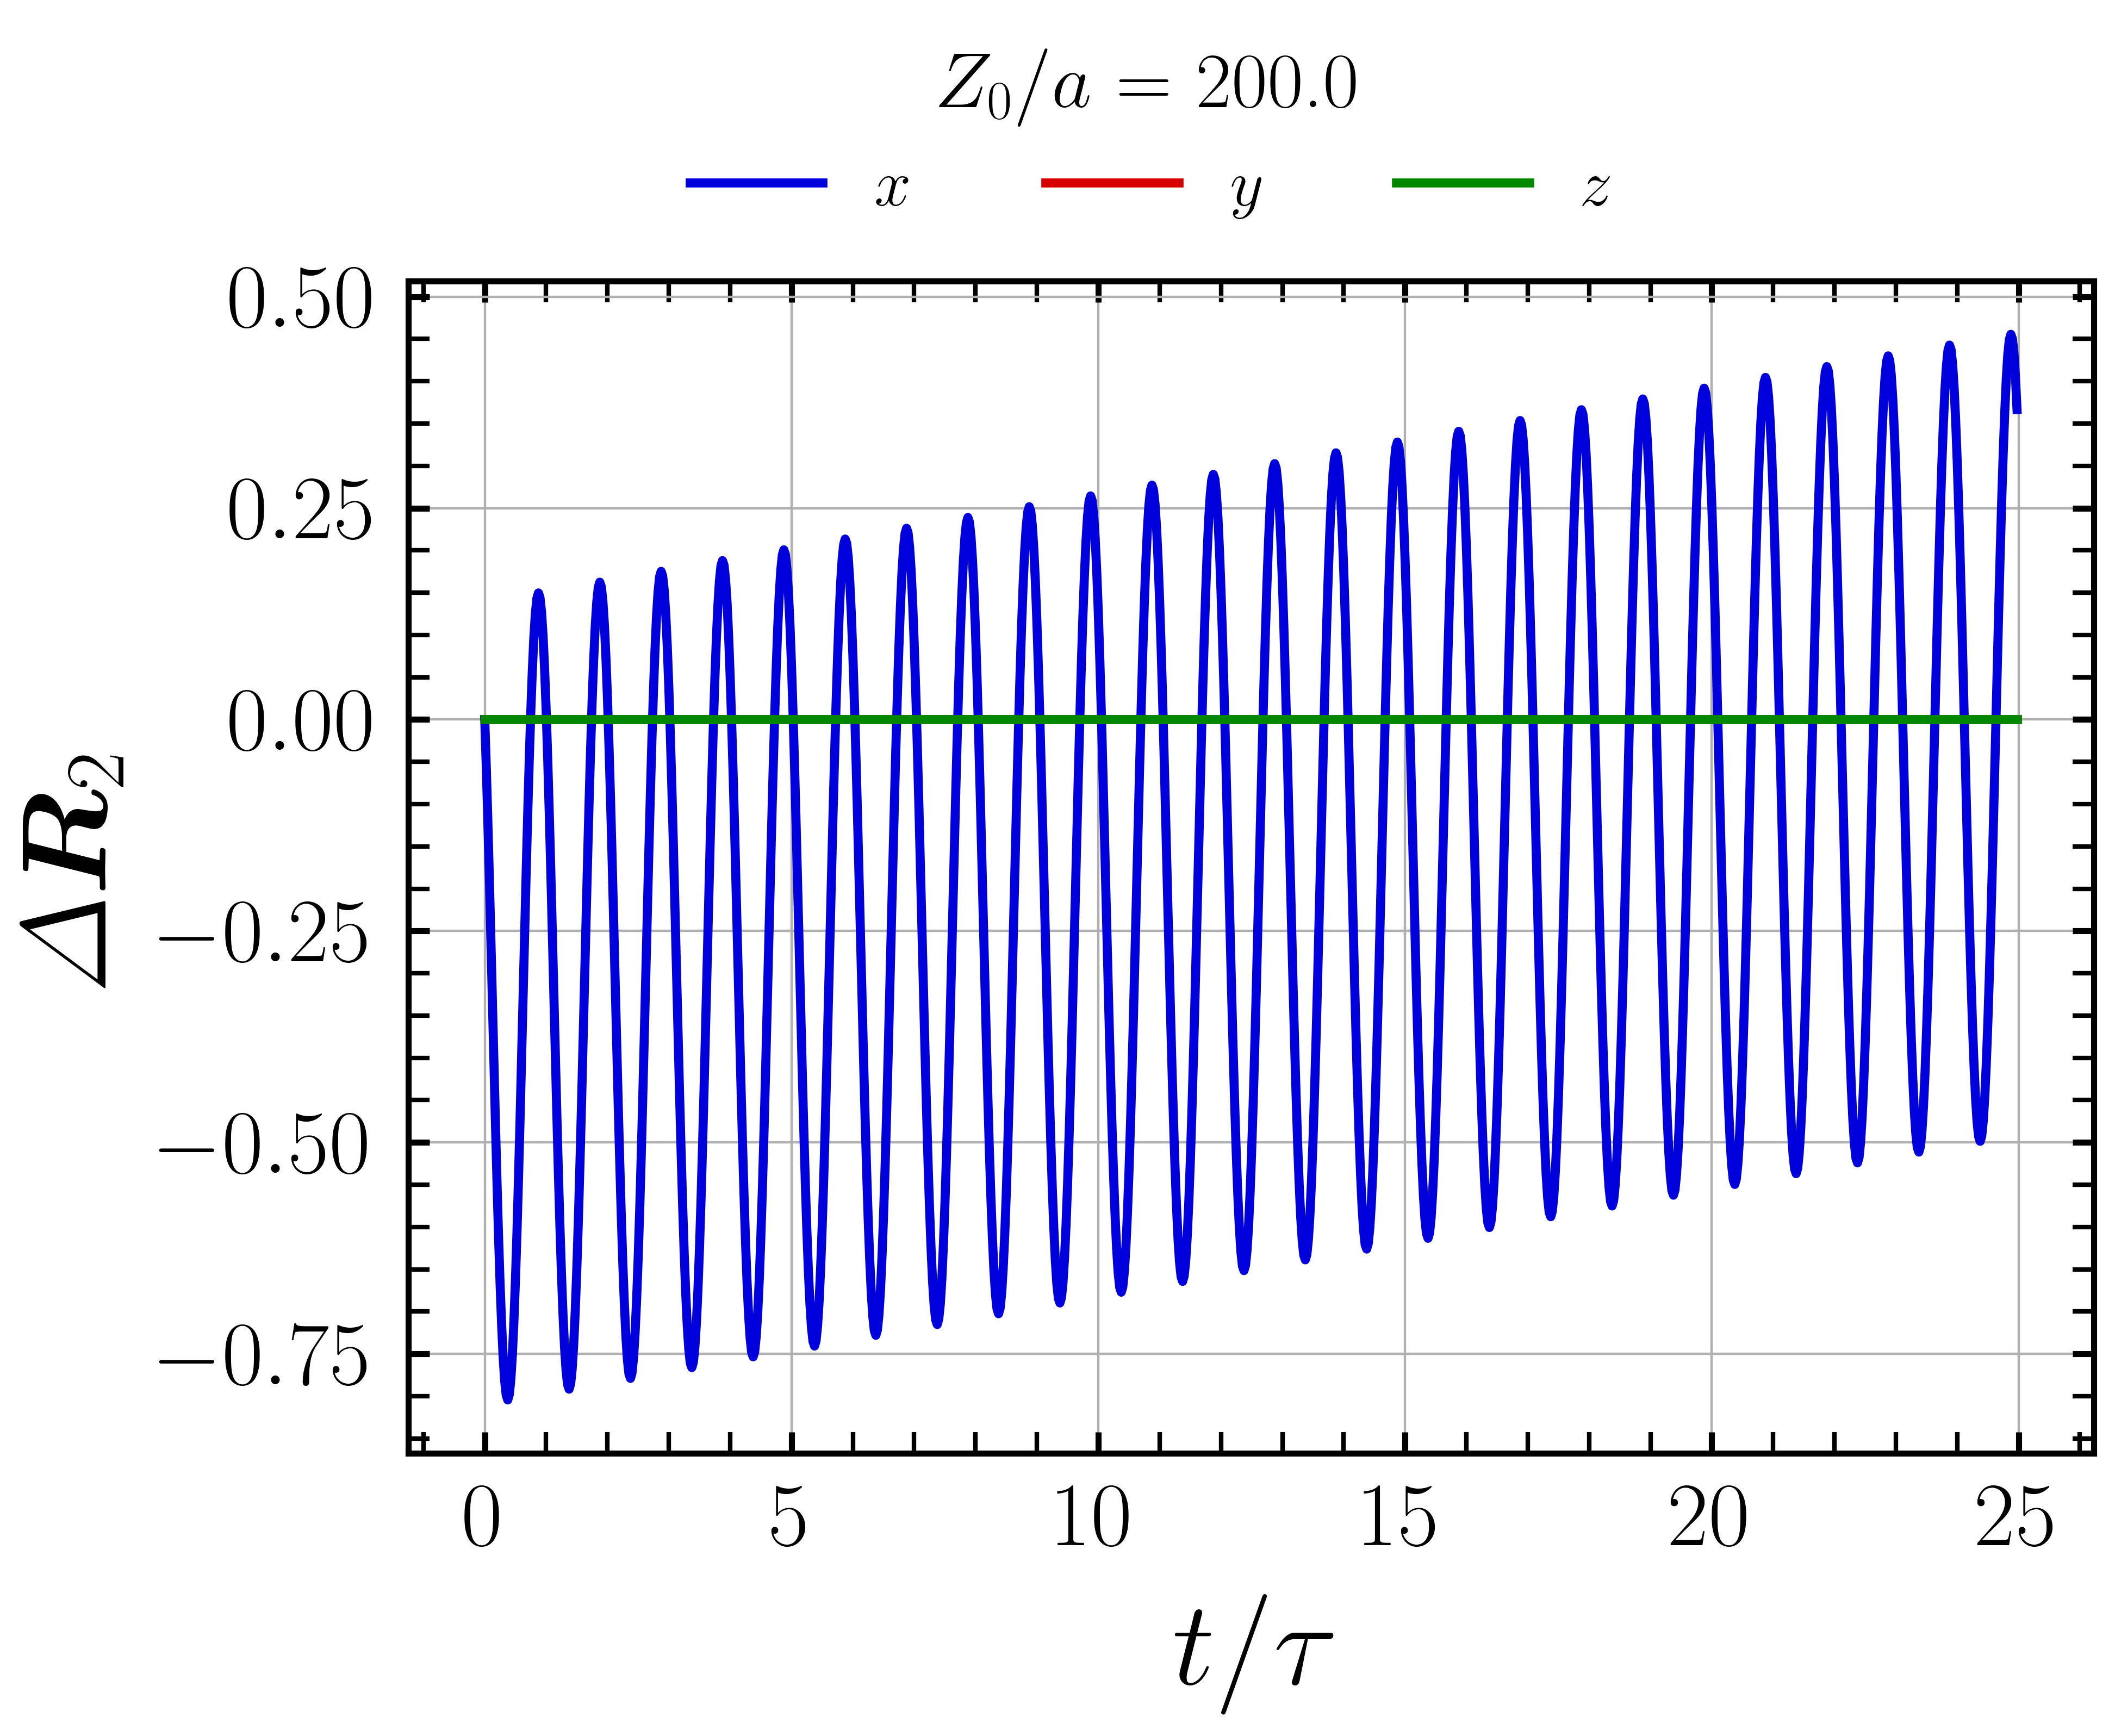

In [57]:
# PLOT: Position of particle 2
simNumber = -1

numLines = 3
p2Pos_Plot = PlotStyling(numLines,
                         r"$t/\tau$", r"$ \Delta \bm{R}_{2}$",
                         title=None, loglog=False,
                         outputDir=output_dir, figName="particle-2-pos", eps=epsOutput,
                         continuousColors=False)
# Show numerical data points
p2Pos_Plot.make_plot(showPlot=True)
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 0, :], zorder=i, label=r"$x$")
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 1, :], zorder=i, label=r"$y$")
p2Pos_Plot.curve(time[i, :], DR_loc[simNumber, 2, :], zorder=i, label=r"$z$")
# plot elements
p2Pos_Plot.set_major_minor_ticks(xMajorLoc=5, xMinorLoc=1, yMajorLoc=0.25, yMinorLoc=0.05)
p2Pos_Plot.ax.grid('True')
# text elements
p2Pos_Plot.legend(title=r"$Z_0/a$ = " + f"{Z_height[simNumber]}",
                  loc='best', ncol=3, bbox_to_anchor=(0.05, 0.05, 0.7, 1.2))

# other outputs
dR_x_far = DR_loc[simNumber, 0, 960] - DR_loc[simNumber, 0, 0]
print(f"dR_x = {DR_loc[simNumber, 0, 960] - DR_loc[simNumber, 0, 0]}")
print(f"dR_y = {DR_loc[simNumber, 1, 960] - DR_loc[simNumber, 1, 0]}")
print(f"dR_z = {DR_loc[simNumber, 2, 960] - DR_loc[simNumber, 2, 0]}")

# show plot
p2Pos_Plot.fig


In [59]:
print(f"% change in x-disp: {(dR_x_close - dR_x_far)/dR_x_close * 100.0}")

% change in x-disp: -1.9463583359246763
